In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression


In [2]:
#load social distance and prep for join
social_dist_county_df = pd.read_pickle('data/social_dist_county_df.pkl').reset_index()
social_dist_county_df['date'] = pd.to_datetime(social_dist_county_df['date_range_start'], utc=True).dt.date
social_dist_county_df = social_dist_county_df.set_index(['county_fips', 'date'])
social_dist_county_df['median_home_dwell_time_pct'] = social_dist_county_df['weighted_median_home_dwell_time'] / (24*60)
social_dist_county_df.head()

date_range_start  \
county_fips date                                    
01001       2020-01-01  2020-01-01T00:00:00-06:00   
            2020-01-02  2020-01-02T00:00:00-06:00   
            2020-01-03  2020-01-03T00:00:00-06:00   
            2020-01-04  2020-01-04T00:00:00-06:00   
            2020-01-05  2020-01-05T00:00:00-06:00   

                        weighted_median_home_dwell_time  \
county_fips date                                          
01001       2020-01-01                       862.324202   
            2020-01-02                       788.174935   
            2020-01-03                       851.749532   
            2020-01-04                       901.223637   
            2020-01-05                       858.221875   

                        adjusted_completely_home_device_count  population  \
county_fips date                                                            
01001       2020-01-01                            1592.017619       55049   
            2020-01-02                            1066.545585       55049   
            2020-01-03                            1088.331144       55049   
            2020-01-04                            1164.661161       55049   
            2020-01-05                            1267.118845       55049   

                        device_count  pct_staying_home  \
county_fips date                                         
01001       2020-01-01          5315          0.299533   
            2020-01-02          5192          0.205421   
            2020-01-03          5234          0.207935   
            2020-01-04          5127          0.227162   
            2020-01-05          5112          0.247871   

                        median_home_dwell_time_pct  
county_fips date                                    
01001       2020-01-01                    0.598836  
            2020-01-02                    0.547344  
            2020-01-03                    0.591493  
            2020-01-04                    0.625850  
            2020-01-05                    0.595987

In [3]:
#load epidemiology and prep for join
epidemiology_df = pd.read_pickle('data/us_data_with_latent_populations.pkl').reset_index()
epidemiology_df['county_fips'] = epidemiology_df['UID'].apply(lambda x: x[3:])
epidemiology_df = epidemiology_df.set_index(['county_fips', 'date'])
epidemiology_df['infections_as_ratio_of_case_based_infectious_population'] = epidemiology_df['infections_based_on_cases'] / epidemiology_df[
    'case_based_infectious_population']


In [4]:
#join on county FIPS

sd_epi_df = epidemiology_df.join(social_dist_county_df, how='inner')

Remove nans and extreme values for plotting

In [14]:
with pd.option_context('mode.use_inf_as_na', True):
    #sd_epi_df = sd_epi_df.dropna(subset=['infections_as_ratio_of_case_based_infectious_population'])
       
    data_filter = np.all(np.array([
            sd_epi_df['infections_as_ratio_of_case_based_infectious_population'].notna().values,
            sd_epi_df['infections_as_ratio_of_case_based_infectious_population'] < 2,
            sd_epi_df['case_based_infectious_population'] > 20,
            sd_epi_df.reset_index()['date'] < pd.datetime.today() - pd.Timedelta(10, 'days')
    ]), axis=0)

data = sd_epi_df[data_filter].copy()

<ipython-input-14-503684ca21ef>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  sd_epi_df.reset_index()['date'] < pd.datetime.today() - pd.Timedelta(10, 'days')


### Scatter plot, kde and fit of percent of devices staying home all day

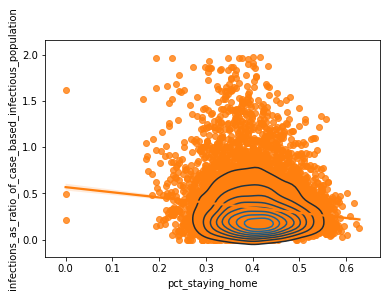

In [7]:
sns.kdeplot(data=data['pct_staying_home'], data2=data['infections_as_ratio_of_case_based_infectious_population'])
sns.regplot(data=data, x='pct_staying_home', y='infections_as_ratio_of_case_based_infectious_population')

In [9]:
X = data['pct_staying_home'].values.reshape(-1,1)
y = data['infections_as_ratio_of_case_based_infectious_population']
reg = LinearRegression().fit(X,y)

print(reg.coef_)

[-0.55628707]


### Scatter plot, kde and fit of percent of median home dwell time (as percent of 24 hours)

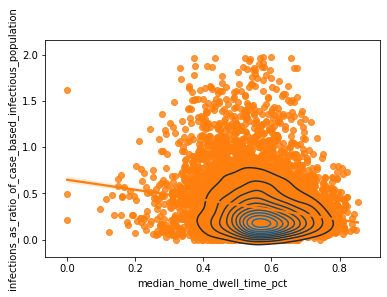

In [11]:
sns.kdeplot(data=data['median_home_dwell_time_pct'], data2=data['infections_as_ratio_of_case_based_infectious_population'])
sns.regplot(data=data, x='median_home_dwell_time_pct', y='infections_as_ratio_of_case_based_infectious_population')

In [12]:
X = data['median_home_dwell_time_pct'].values.reshape(-1,1)
y = data['infections_as_ratio_of_case_based_infectious_population']
reg = LinearRegression().fit(X,y)

print(reg.coef_)

[-0.54086949]


So there is an apparent association between metrics of social distancing and the number of new infections as a percentage of current infectious population in a given day (the contact rate proxy if we assume low numbers of exposure history).

### Looking at it as a time series

In [15]:
#Looking over time at aggregate level
data['n_home'] = data['pct_staying_home'] * data['population']
us_aggregate = data.groupby('date').aggregate(
    infections_based_on_cases = ("infections_based_on_cases", sum),
    case_based_infectious_population = ('case_based_infectious_population', sum),
    population = ('population',sum),
    n_home = ('n_home',sum)
    ).reset_index()

us_aggregate['infections_as_ratio_of_case_based_infectious_population'] = us_aggregate['infections_based_on_cases'] / us_aggregate[
    'case_based_infectious_population']

us_aggregate['pct_staying_home'] = us_aggregate['n_home']/us_aggregate['population']

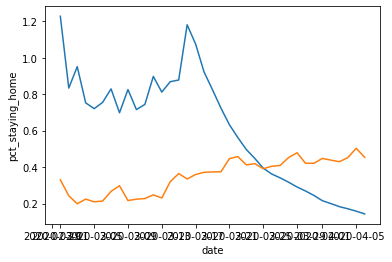

In [16]:
fig, ax = plt.subplots()

ax = sns.lineplot(data=us_aggregate, x='date', y='infections_as_ratio_of_case_based_infectious_population', ax=ax)
ax2 = sns.lineplot(data=us_aggregate, x='date', y='pct_staying_home')